In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import math
import random
import pickle

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, Concatenate, Dot, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model, to_categorical


plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
np.set_printoptions(linewidth=150)

In [3]:
data_path = "data"

In [4]:
train_data = pd.read_csv(os.path.join(data_path, "Train_Data_Final.csv"))

In [5]:
train_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,RH_type,id
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,0.757754,Ideal,1
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,0.725487,Ideal,2
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,0.750239,Slightly Elevated,3
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,0.786713,Slightly Elevated,4
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,0.788794,Slightly Elevated,5


In [6]:
train_data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'AH', 'RH_type', 'id'],
      dtype='object')

In [7]:
type(train_data['Time'].loc[0])

str

In [8]:
train_data["DateTime"] = train_data["Date"] + ' ' + train_data["Time"]

In [9]:
train_data["DateTime"]

0       2004-03-10 18:00:00
1       2004-03-10 19:00:00
2       2004-03-10 20:00:00
3       2004-03-10 21:00:00
4       2004-03-10 22:00:00
               ...         
7995    2005-02-06 21:00:00
7996    2005-02-06 22:00:00
7997    2005-02-06 23:00:00
7998    2005-02-07 00:00:00
7999    2005-02-07 01:00:00
Name: DateTime, Length: 8000, dtype: object

In [10]:
from datetime import datetime

In [11]:
train_data['date&time'] = train_data['DateTime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [12]:
train_data['date&time']

0      2004-03-10 18:00:00
1      2004-03-10 19:00:00
2      2004-03-10 20:00:00
3      2004-03-10 21:00:00
4      2004-03-10 22:00:00
               ...        
7995   2005-02-06 21:00:00
7996   2005-02-06 22:00:00
7997   2005-02-06 23:00:00
7998   2005-02-07 00:00:00
7999   2005-02-07 01:00:00
Name: date&time, Length: 8000, dtype: datetime64[ns]

In [13]:
train_data["timestamp"] = pd.to_datetime(train_data['date&time']).astype('int64')/ 10**18

In [14]:
train_data["timestamp"]

0       1.078942
1       1.078945
2       1.078949
3       1.078952
4       1.078956
          ...   
7995    1.107724
7996    1.107727
7997    1.107731
7998    1.107734
7999    1.107738
Name: timestamp, Length: 8000, dtype: float64

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_data["RH_type"] = le.fit_transform(train_data["RH_type"])

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8000 non-null   object        
 1   Time           8000 non-null   object        
 2   CO(GT)         8000 non-null   float64       
 3   PT08.S1(CO)    8000 non-null   float64       
 4   NMHC(GT)       8000 non-null   int64         
 5   C6H6(GT)       8000 non-null   float64       
 6   PT08.S2(NMHC)  8000 non-null   float64       
 7   NOx(GT)        8000 non-null   float64       
 8   PT08.S3(NOx)   8000 non-null   float64       
 9   NO2(GT)        8000 non-null   float64       
 10  PT08.S4(NO2)   8000 non-null   float64       
 11  PT08.S5(O3)    8000 non-null   float64       
 12  T              8000 non-null   float64       
 13  AH             8000 non-null   float64       
 14  RH_type        8000 non-null   int32         
 15  id             8000 n

In [17]:
train_data = train_data.drop(["Date", "Time", "date&time", "DateTime"], axis = 1)

In [18]:
train_data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,RH_type,id,timestamp
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,0.757754,3,1,1.078942
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,0.725487,3,2,1.078945
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,0.750239,4,3,1.078949
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,0.786713,4,4,1.078952
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,0.788794,4,5,1.078956


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8000 non-null   float64
 1   PT08.S1(CO)    8000 non-null   float64
 2   NMHC(GT)       8000 non-null   int64  
 3   C6H6(GT)       8000 non-null   float64
 4   PT08.S2(NMHC)  8000 non-null   float64
 5   NOx(GT)        8000 non-null   float64
 6   PT08.S3(NOx)   8000 non-null   float64
 7   NO2(GT)        8000 non-null   float64
 8   PT08.S4(NO2)   8000 non-null   float64
 9   PT08.S5(O3)    8000 non-null   float64
 10  T              8000 non-null   float64
 11  AH             8000 non-null   float64
 12  RH_type        8000 non-null   int32  
 13  id             8000 non-null   int64  
 14  timestamp      8000 non-null   float64
dtypes: float64(12), int32(1), int64(2)
memory usage: 906.4 KB


In [20]:
train_data_temp = train_data.copy()

In [22]:
train_data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'AH', 'RH_type', 'id', 'timestamp'],
      dtype='object')

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_set, test_set = train_test_split(train_data, test_size = 0.15, random_state = 8420)

In [25]:
train_set.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,RH_type,id,timestamp
2091,0.6,840.75,-200,3.781731,698.50,17.0,1123.00,30.0,1507.50,557.50,23.025,1.417541,4,2092,1.086469
387,1.5,1000.75,97,5.982909,811.00,99.0,1097.25,91.0,1308.25,777.75,9.825,0.617183,4,388,1.080335
5457,1.5,1049.50,-200,8.406517,915.75,-200.0,696.25,-200.0,1512.25,997.00,19.300,1.574622,2,5458,1.098587
7672,1.4,991.50,-200,5.738410,799.50,327.0,797.00,183.2,1006.75,933.75,8.650,0.524864,3,7673,1.106561
3972,-200.0,808.50,-200,3.830373,701.25,-200.0,996.50,-200.0,1383.75,649.00,21.125,1.278447,4,3973,1.093241


In [26]:
## Analysis for train set

train_set_ids = train_set.pop("id")
test_set_ids = test_set.pop("id")

In [27]:
train_set_labels = train_set.pop("RH_type")
test_set_labels = test_set.pop("RH_type")

In [28]:
train_set.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,timestamp
2091,0.6,840.75,-200,3.781731,698.50,17.0,1123.00,30.0,1507.50,557.50,23.025,1.417541,1.086469
387,1.5,1000.75,97,5.982909,811.00,99.0,1097.25,91.0,1308.25,777.75,9.825,0.617183,1.080335
5457,1.5,1049.50,-200,8.406517,915.75,-200.0,696.25,-200.0,1512.25,997.00,19.300,1.574622,1.098587
7672,1.4,991.50,-200,5.738410,799.50,327.0,797.00,183.2,1006.75,933.75,8.650,0.524864,1.106561
3972,-200.0,808.50,-200,3.830373,701.25,-200.0,996.50,-200.0,1383.75,649.00,21.125,1.278447,1.093241


In [29]:
train_set.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'AH', 'timestamp'],
      dtype='object')

In [27]:
X_train = train_set.values
Y_train = train_set_labels.values
X_test = test_set.values
Y_test = test_set_labels.values

In [28]:
# norm = np.linalg.norm(X_train)         # To find the norm of the array
# X_train = X_train/norm  # Formula used to perform array normalization


#### **Logistic Regression**


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Train Accuracy:	46.6%


              precision    recall  f1-score   support

           0       0.71      0.64      0.67      1347
           1       0.35      0.32      0.33      1038
           2       0.52      0.24      0.33       827
           3       0.44      0.74      0.55      2286
           4       0.22      0.07      0.10      1302

    accuracy                           0.47      6800
   macro avg       0.45      0.40      0.40      6800
weighted avg       0.45      0.47      0.43      6800

Test Accuracy:	44.9%


              precision    recall  f1-score   support

           0       0.67      0.60      0.63       223
           1       0.39      0.31      0.35       210
           2       0.46      0.19      0.27       152
           3       0.42      0.75      0.54       387
           4       0.24      0.08      0.12       228

    accuracy                           0.45      1200
   macro avg       0.44      0.39      0.38      1200
weighted avg       0.43      0

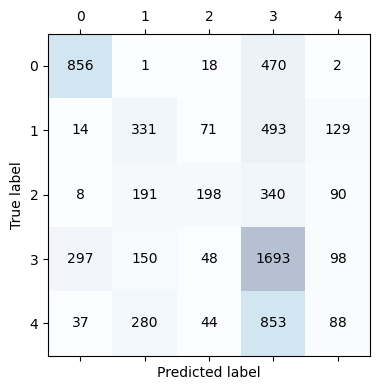

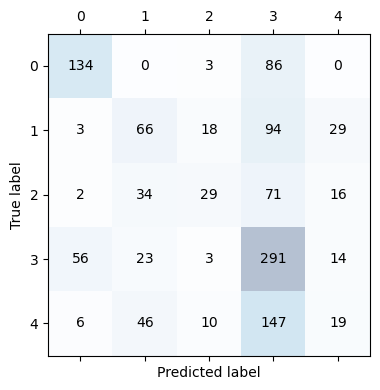

In [29]:

from sklearn.linear_model import LogisticRegression

clf_logr = LogisticRegression()
#create a dictionary of all values we want to test for parameters
params_logr = {}
#use gridsearch to test all values for parameters
clf_logr = GridSearchCV(clf_logr, params_logr, cv=5)
clf_logr.fit(X_train, Y_train)


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_logr.predict(X_train)
def model_evaluate(): 
    
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_logr.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **Decision Tree Classifier**

Train Accuracy:	100.0%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       827
           3       1.00      1.00      1.00      2286
           4       1.00      1.00      1.00      1302

    accuracy                           1.00      6800
   macro avg       1.00      1.00      1.00      6800
weighted avg       1.00      1.00      1.00      6800

Test Accuracy:	91.7%


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       223
           1       0.90      0.85      0.88       210
           2       0.91      0.95      0.93       152
           3       0.94      0.94      0.94       387
           4       0.87      0.89      0.88       228

    accuracy                           0.92      1200
   macro avg       0.91      0.92      0.91      1200
weighted avg       0.92      

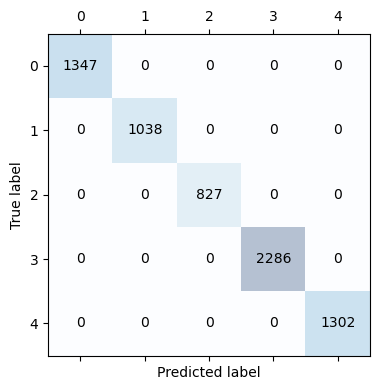

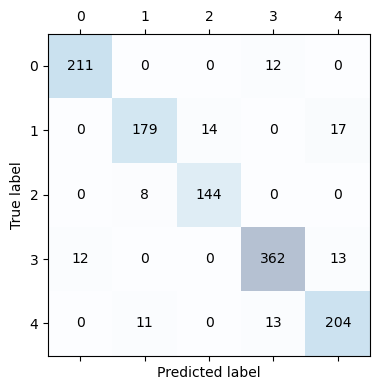

In [30]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
#create a dictionary of all values we want to test for parameters
params_dt = {}
#use gridsearch to test all values for parameters
clf_dt = GridSearchCV(clf_dt, params_dt, cv=5)
clf_dt.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_dt.predict(X_train)
def model_evaluate(): 
    
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_dt.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **SVM Model**


Test Accuracy:	48.5%


              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1347
           1       0.50      0.10      0.17      1038
           2       0.63      0.26      0.37       827
           3       0.41      0.92      0.57      2286
           4       0.45      0.06      0.10      1302

    accuracy                           0.48      6800
   macro avg       0.57      0.39      0.38      6800
weighted avg       0.54      0.48      0.42      6800

Test Accuracy:	44.6%


              precision    recall  f1-score   support

           0       0.80      0.56      0.66       223
           1       0.41      0.09      0.15       210
           2       0.61      0.22      0.32       152
           3       0.38      0.90      0.53       387
           4       0.34      0.04      0.08       228

    accuracy                           0.45      1200
   macro avg       0.51      0.36      0.35      1200
weighted avg       0.49      0.

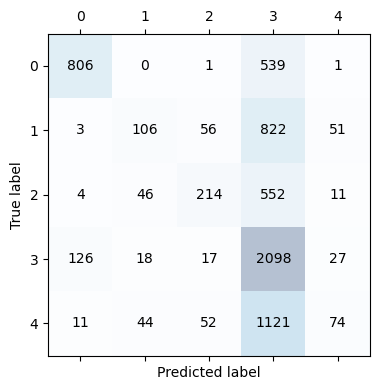

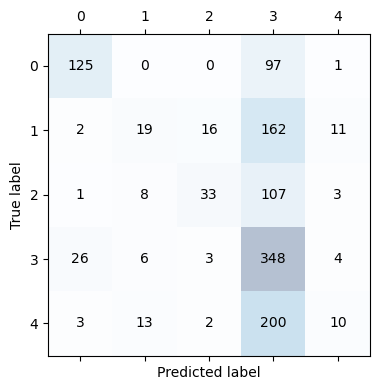

In [31]:

from sklearn.svm import SVC

clf_svc = SVC()
#create a dictionary of all values we want to test for parameters
params_svc = {}
#use gridsearch to test all values for parameters
clf_svc = GridSearchCV(clf_svc, params_svc, cv=5)
clf_svc.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_svc.predict(X_train)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_svc.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **Random Forest**

Test Accuracy:	100.0%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       827
           3       1.00      1.00      1.00      2286
           4       1.00      1.00      1.00      1302

    accuracy                           1.00      6800
   macro avg       1.00      1.00      1.00      6800
weighted avg       1.00      1.00      1.00      6800

Test Accuracy:	84.7%


              precision    recall  f1-score   support

           0       0.94      0.91      0.93       223
           1       0.75      0.68      0.71       210
           2       0.83      0.87      0.85       152
           3       0.89      0.93      0.91       387
           4       0.76      0.79      0.77       228

    accuracy                           0.85      1200
   macro avg       0.84      0.83      0.84      1200
weighted avg       0.85      0

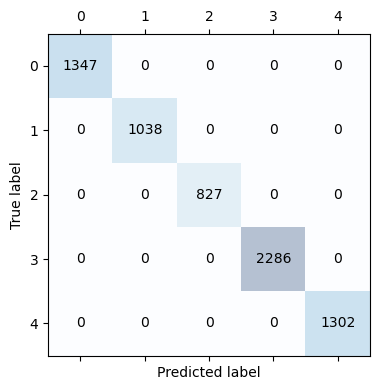

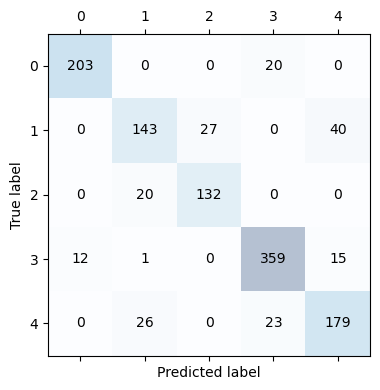

In [32]:
from sklearn.ensemble import RandomForestClassifier


clf_rf = RandomForestClassifier()
#create a dictionary of all values we want to test for parameters
params_rf = {}
#use gridsearch to test all values for parameters
clf_rf = GridSearchCV(clf_rf, params_rf, cv=5)
clf_rf.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_rf.predict(X_train)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_rf.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **XGBoost Model**


In [33]:
# !pip install xgboost


Train Accuracy:	100.0%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       827
           3       1.00      1.00      1.00      2286
           4       1.00      1.00      1.00      1302

    accuracy                           1.00      6800
   macro avg       1.00      1.00      1.00      6800
weighted avg       1.00      1.00      1.00      6800

Test Accuracy:	94.5%


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       223
           1       0.93      0.88      0.91       210
           2       0.96      0.96      0.96       152
           3       0.96      0.97      0.96       387
           4       0.89      0.93      0.91       228

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.95      

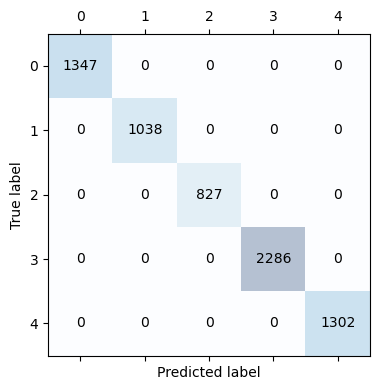

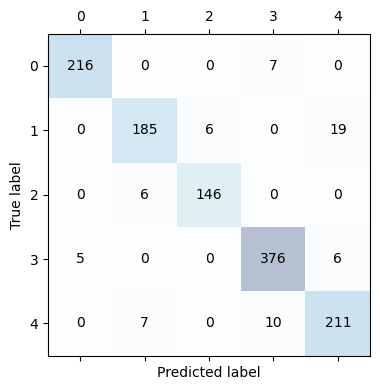

In [34]:
from xgboost import XGBClassifier


clf_xgb = XGBClassifier()
#create a dictionary of all values we want to test for parameters
params_xgb = {}
#use gridsearch to test all values for parameters
clf_xgb = GridSearchCV(clf_xgb, params_xgb, cv=5)
clf_xgb.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_xgb.predict(X_train)
def model_evaluate(): 
    
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_xgb.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **CatBoost Model**


In [35]:
# !pip install catboost

Learning rate set to 0.086266
0:	learn: 1.5084977	total: 146ms	remaining: 2m 25s
1:	learn: 1.4431271	total: 152ms	remaining: 1m 15s
2:	learn: 1.3865053	total: 159ms	remaining: 52.7s
3:	learn: 1.3308509	total: 166ms	remaining: 41.2s
4:	learn: 1.2753527	total: 172ms	remaining: 34.3s
5:	learn: 1.2345755	total: 179ms	remaining: 29.7s
6:	learn: 1.1831106	total: 186ms	remaining: 26.4s
7:	learn: 1.1354624	total: 192ms	remaining: 23.9s
8:	learn: 1.0983135	total: 200ms	remaining: 22s
9:	learn: 1.0554779	total: 207ms	remaining: 20.5s
10:	learn: 1.0245848	total: 214ms	remaining: 19.2s
11:	learn: 1.0007285	total: 220ms	remaining: 18.1s
12:	learn: 0.9726059	total: 226ms	remaining: 17.2s
13:	learn: 0.9487933	total: 235ms	remaining: 16.5s
14:	learn: 0.9248455	total: 241ms	remaining: 15.8s
15:	learn: 0.9035769	total: 247ms	remaining: 15.2s
16:	learn: 0.8796211	total: 254ms	remaining: 14.7s
17:	learn: 0.8671065	total: 261ms	remaining: 14.2s
18:	learn: 0.8539444	total: 268ms	remaining: 13.8s
19:	learn: 

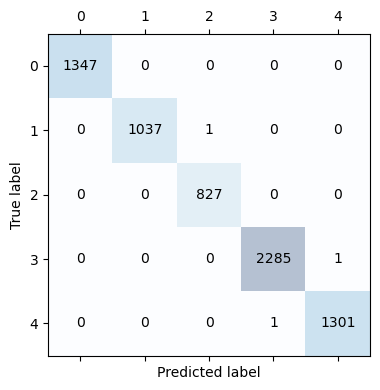

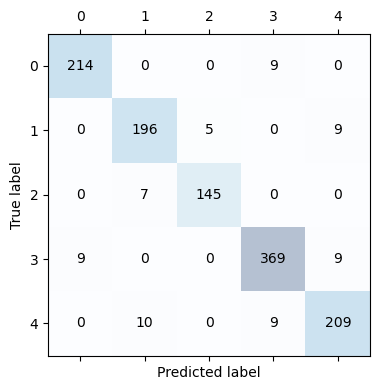

In [36]:
from catboost import CatBoostClassifier


clf_cat = CatBoostClassifier(iterations = 1000)
#create a dictionary of all values we want to test for parameters
params_cat = {}
#use gridsearch to test all values for parameters
clf_cat = GridSearchCV(clf_cat, params_cat, cv=5)
clf_cat.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_cat.predict(X_train)
def model_evaluate(): 
    
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_cat.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **LightGBM Model**

In [37]:
# !pip install lightgbm


Train Accuracy:	100.0%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       827
           3       1.00      1.00      1.00      2286
           4       1.00      1.00      1.00      1302

    accuracy                           1.00      6800
   macro avg       1.00      1.00      1.00      6800
weighted avg       1.00      1.00      1.00      6800

Test Accuracy:	94.8%


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       223
           1       0.92      0.90      0.91       210
           2       0.96      0.95      0.96       152
           3       0.96      0.98      0.97       387
           4       0.92      0.91      0.91       228

    accuracy                           0.95      1200
   macro avg       0.95      0.94      0.95      1200
weighted avg       0.95      

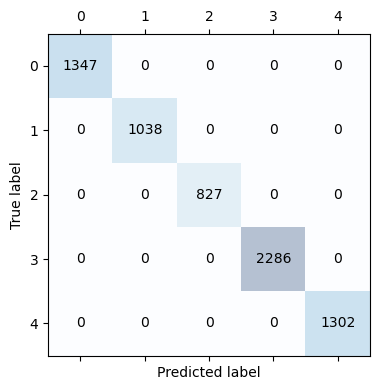

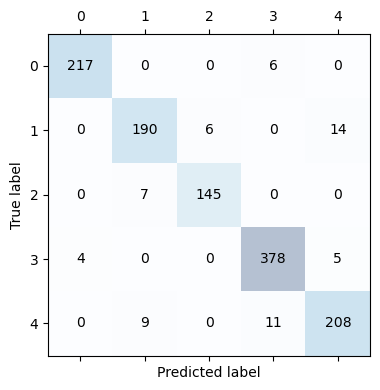

In [38]:
import lightgbm as lgb

clf_lgbm = lgb.LGBMClassifier()
#create a dictionary of all values we want to test for parameters
params_lgbm = {}
#use gridsearch to test all values for parameters
clf_lgbm = GridSearchCV(clf_lgbm, params_lgbm, cv=5)
clf_lgbm.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_lgbm.predict(X_train)
def model_evaluate(): 
    
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_lgbm.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


#### **Ensemble Model**

In [39]:
log_r = clf_logr.best_estimator_
dt = clf_dt.best_estimator_
svc = clf_svc.best_estimator_
rf = clf_rf.best_estimator_
xgb = clf_xgb.best_estimator_
cat = clf_cat.best_estimator_
lgbm = clf_lgbm.best_estimator_

In [40]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgb", xgb), ("lgbm", lgbm)]
#create our voting classifier, inputting our models
clf_ensemble = VotingClassifier(estimators, voting="hard")

In [41]:
#fit model to training data
clf_ensemble.fit(X_train, Y_train)
#test our model on the test data
clf_ensemble.score(X_test, Y_test)

0.9466666666666667

Train Accuracy:	100.0%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1347
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       827
           3       1.00      1.00      1.00      2286
           4       1.00      1.00      1.00      1302

    accuracy                           1.00      6800
   macro avg       1.00      1.00      1.00      6800
weighted avg       1.00      1.00      1.00      6800

Test Accuracy:	94.7%


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       223
           1       0.90      0.92      0.91       210
           2       0.97      0.95      0.96       152
           3       0.95      0.98      0.97       387
           4       0.93      0.88      0.91       228

    accuracy                           0.95      1200
   macro avg       0.95      0.94      0.94      1200
weighted avg       0.95      

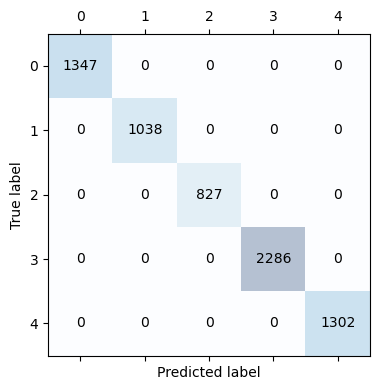

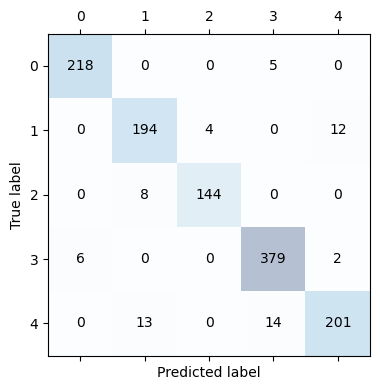

In [42]:
clf_ensemble.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_ensemble.predict(X_train)
def model_evaluate(): 
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_ensemble.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


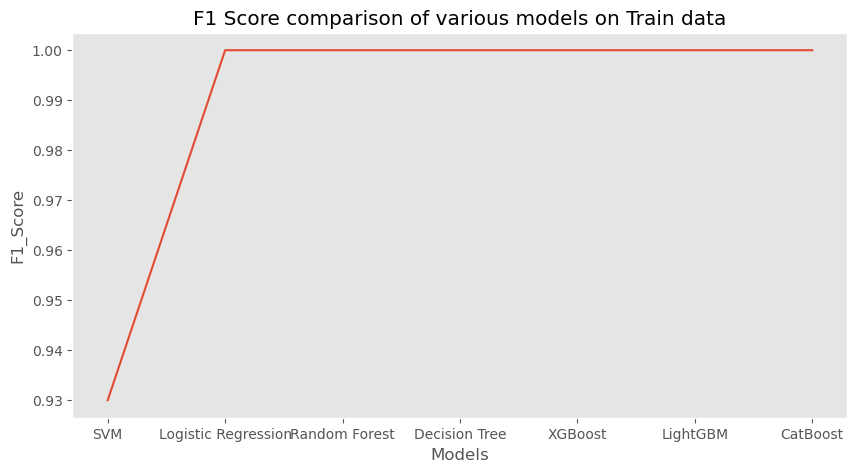

In [43]:
import pandas as pd
train_results = {}
test_results = {}

train_results["Logistic Regression"] = {"Accuracy": 99.7, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}
train_results["Random Forest"] = {"Accuracy": 100, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}
train_results["Decision Tree"] = {"Accuracy": 100, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}
train_results["SVM"] = {"Accuracy": 93.5, "Precision": 0.95, "Recall": 0.94, "F1_Score": 0.93, "Support": 340}
train_results["XGBoost"] = {"Accuracy": 100, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}
train_results["LightGBM"] = {"Accuracy": 100, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}
train_results["CatBoost"] = {"Accuracy": 100, "Precision": 1, "Recall": 1, "F1_Score": 1, "Support": 340}

test_results["Logistic Regression"] = {"Accuracy": 95.3, "Precision": 0.96, "Recall": 0.95, "F1_Score": 0.95, "Support": 85}
test_results["Random Forest"] = {"Accuracy": 91.8, "Precision": 0.91, "Recall": 0.89, "F1_Score": 0.90, "Support": 85}
test_results["Decision Tree"] = {"Accuracy": 98.8, "Precision": 0.99, "Recall": 0.99, "F1_Score": 0.99, "Support": 85}
test_results["SVM"] = {"Accuracy": 91.8, "Precision": 0.92, "Recall": 0.92, "F1_Score": 0.91, "Support": 85}
test_results["XGBoost"] = {"Accuracy": 96.5, "Precision": 0.97, "Recall": 0.96, "F1_Score": 0.97, "Support": 85}
test_results["LightGBM"] = {"Accuracy": 98.8, "Precision": 0.99, "Recall": 0.99, "F1_Score": 0.99, "Support": 85}
test_results["CatBoost"] = {"Accuracy": 96.5, "Precision": 0.97, "Recall": 0.96, "F1_Score": 0.96, "Support": 85}

train_results_df = pd.DataFrame(train_results)
test_results_df = pd.DataFrame(test_results)

test_results_df = test_results_df.T
train_results_df = train_results_df.T

train_results_df = train_results_df.sort_values(by = "F1_Score")
train_results_df

# accuracy comparison

y = train_results_df["F1_Score"]
x = train_results_df.index
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))

plt.plot(x, y)
plt.xlabel("Models")
plt.ylabel("F1_Score")
plt.title("F1 Score comparison of various models on Train data")
plt.grid(False)
plt.show()

In [44]:
# !pip install mljar-supervised

In [48]:
# !pip install torch


In [49]:
import torch

OSError: [WinError 182] The operating system cannot run %1. Error loading "C:\Users\DELL\anaconda3\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [50]:

from supervised.automl import AutoML

OSError: [WinError 182] The operating system cannot run %1. Error loading "C:\Users\DELL\anaconda3\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [45]:
# import pandas as pd 
# scikit learn utilites
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# mljar-supervised package
from supervised.automl import AutoML

# train models with AutoML
automl = AutoML(mode="Perform")
clf_lgbm.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_lgbm.predict(X_train)
def model_evaluate(): 
    
    print('Train Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_train ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_train, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_train, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

Y_pred = clf_lgbm.predict(X_test)
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(Y_test ,Y_pred)*100))
    
    #classification report
    print('\n')
    print(classification_report(Y_test, Y_pred))

    #confusion matrix
    confmat = confusion_matrix(Y_test, Y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model_evaluate()


OSError: [WinError 182] The operating system cannot run %1. Error loading "C:\Users\DELL\anaconda3\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.